# Set Parameter
- Attention = True
- Drop out = 0.2
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Hidden unit = 50
- Batch size = 32
- Epochs = 50

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer_unmatching import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


# Data load

In [2]:
train_path = "unmatching_data/data_train.txt"
dev_path = "unmatching_data/data_test.txt"
log_level = 'info'

# Log format

In [3]:
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Prepare dataset

In [4]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 100
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Prepare loss

In [5]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Variable definition

In [6]:
seq2seq = None
optimizer = "Adam"

hidden_sizes = list(range(50, 51, 4))
print(hidden_sizes)
error_rate = []
accuracy = []
losses = []

[50]


# Initialize model

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-01-31 17:17:17,269 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Hidden size is 50


/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-01-31 17:22:30,884 INFO   Finished epoch 1: Train loss: 2.1684, Dev loss: 2.3400, Accuracy: 0.7334, F1 Score: 0.2678
2019-01-31 17:27:44,323 INFO   Finished epoch 2: Train loss: 1.9991, Dev loss: 1.9467, Accuracy: 0.7682, F1 Score: 0.1757
2019-01-31 17:33:03,058 INFO   Finished epoch 3: Train loss: 1.9278, Dev loss: 1.9253, Accuracy: 0.7732, F1 Score: 0.1985
2019-01-31 17:38:15,404 INFO   Finished epoch 4: Train loss: 1.9114, Dev loss: 1.9223, Accuracy: 0.7741, F1 Score: 0.2188
2019-01-31 17:45:57,621 INFO   Finished epoch 5: Train loss: 1.8747, Dev loss: 1.8520, Accuracy: 0.7737, F1 Score: 0.2071
2019-01-31 17:54:47,362 INFO   Finished epoch 6: Train loss: 1.7142, Dev loss: 1.6435, Accuracy: 0.7910, F1 Score: 0.4185
2019-01-31 18:03:40,692 INFO   Fini

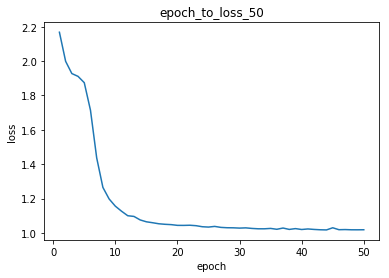

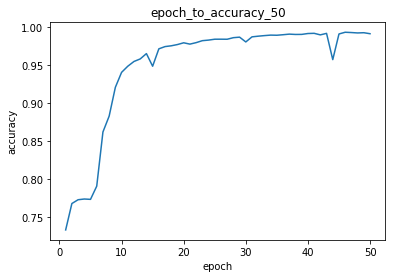

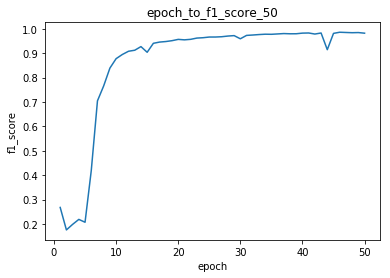

In [7]:
for i in hidden_sizes:
    print("Hidden size is %d" % i)
    hidden_size = i
    bidirectional = True
    encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                        bidirectional=bidirectional, variable_lengths=True)
    decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                        dropout_p=0.2, use_attention=True, bidirectional=bidirectional,
                        eos_id=tgt.eos_id, sos_id=tgt.sos_id)
    seq2seq = Seq2seq(encoder, decoder)
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = SupervisedTrainer(loss=loss, batch_size=32,
                        checkpoint_every=50,
                        print_every=100,
                        hidden_size=hidden_size,
                        fig_path="log/plot/unmatching_att")

    seq2seq, ave_loss, character_accuracy = t.train(seq2seq, train,
                                                    num_epochs=50, dev_data=dev,
                                                    optimizer=optimizer,
                                                    teacher_forcing_ratio=0.5)

    losses.append(ave_loss/100)
    error_rate.append(1 - character_accuracy)
    accuracy.append(character_accuracy)

In [8]:
torch.save(seq2seq.state_dict(), 'log/unmatching_att_model_save.pth')